In [1]:
import decam2hp
import matplotlib.patches as patches
import datetime
import matplotlib.animation
import numpy as np
import healpy as hp
import pandas as pd
import ligo.skymap.plot
from matplotlib import pyplot as plt
from astropy import units as u
import json
import numpy as np
import hp2np 
import hex_object
import hexalate
import decam2hp
import jsonMaker
from os import getenv
import pandas as pd
import sys
import copy
import matplotlib.pyplot as plt
import hex_functions
from astropy.coordinates import SkyCoord
import awesomeness_functions as af
from hex_functions import get_hexinfo 
import time
import OneRing

In [2]:
local_prob, disc_prob = OneRing.run_or('S240413p_flatten.fits', 0.92, 0.50, 'ir', [30, 30], [150, 150], 60415.08, [1, 1], resolution=64, jsonFilename='manual.json')

N hexes in inner= 6  and in outer= 21, total number of hexes=27
mjd is: 60415.08
60415.430555555555 60414.96319444444
False
Loading dust map: .//data/plank-ebv-HFI_CompMap_ThermaDustModel.fits
loading inverse stellar density = probability of recognition map
	 ... the sun is up
	 ... the sun is up
mjd is: 60415.08
60415.430555555555 60414.96319444444
False
Loading dust map: .//data/plank-ebv-HFI_CompMap_ThermaDustModel.fits
loading inverse stellar density = probability of recognition map
	 ... the sun is up
	 ... the sun is up
Could not do second pass on some hexes.
Could not do second pass on some hexes.
Could not do second pass on some hexes.
Could not do second pass on some hexes.
Could not do second pass on some hexes.
Could not do second pass on some hexes.
Could not do second pass on some hexes.
Could not do second pass on some hexes.
Could not do second pass on some hexes.
At 01:55:12 will observe this hex:
RA: 163.208, DEC: 10.1, PROB: 0.0987, AWESOMENESS: 0.0171
With filter i, 

In [3]:
with open('/data/des80.a/data/eliseke/Main-Injector/manual.json', 'r') as jsonfile:
    hexes = json.load(jsonfile)

hex_coords = np.empty(len(hexes), dtype='object')
filt_list = np.empty(len(hexes), dtype='str')
for i in range(len(hexes)):
    hex_coords[i] = (hexes[i]['RA'], hexes[i]['dec'])
    filt_list[i] = hexes[i]['filter']

In [4]:
import matplotlib.path as mpath

def get_ccd_corners(ccd):
    with open('zeroed_corners.list', 'r') as file:
        header = file.readline().strip().split(',')
        ccd_index = header.index('CCD')
        ccd = f'{ccd}.0'
        corner1_ra_index = header.index('Corner 1 Ra')
        corner1_dec_index = header.index('Corner 1 Dec')
        corner2_ra_index = header.index('Corner 2 Ra')
        corner2_dec_index = header.index('Corner 2 Dec')
        corner3_ra_index = header.index('Corner 3 Ra')
        corner3_dec_index = header.index('Corner 3 Dec')
        corner4_ra_index = header.index('Corner 4 Ra')
        corner4_dec_index = header.index('Corner 4 Dec')
        for line in file:
            columns = line.strip().split(',')
            if columns[ccd_index] == ccd:
                value = 1
                corner1 = [value*float(columns[corner1_ra_index]), value*float(columns[corner1_dec_index])]
                corner2 = [value*float(columns[corner2_ra_index]), value*float(columns[corner2_dec_index])]
                corner3 = [value*float(columns[corner3_ra_index]), value*float(columns[corner3_dec_index])]
                corner4 = [value*float(columns[corner4_ra_index]), value*float(columns[corner4_dec_index])]
                return [corner1, corner2, corner3, corner4]
def get_ipossible(raCenter = 0.0, decCenter=0.0, n=1000, radius=1.4):
    xs = np.linspace(-radius, radius, n)
    ys = np.linspace(-radius, radius, n)
    
    xlist = []
    ylist = []

    for x in xs:
        for y in ys:
            xlist.append(x+raCenter)
            ylist.append(y+decCenter)

    ra = np.array(xlist)
    dec = np.array(ylist) 
    
    i_possible = decam2hp.isCatalogInHex(raCenter, decCenter, ra, dec)

    return(ra[i_possible], dec[i_possible], np.ones(i_possible.size))

def ccd_outlines(ccd_corners):
    # Create a matplotlib Path object
    path_data = []
    for i, (ra, dec) in enumerate(ccd_corners):
#         path_data.append([ra, dec])
        if i == 0:
            # Move to the first corner
            path_data.append((mpath.Path.MOVETO, (ra, dec)))
        else:
            # Draw a line to the next corner
            path_data.append((mpath.Path.LINETO, (ra, dec)))

    # Close the path
    path_data.append((mpath.Path.CLOSEPOLY, (ccd_corners[0][0], ccd_corners[0][1])))

#    Create the matplotlib Path
    codes, verts = zip(*path_data)
    path = mpath.Path(verts, codes)

    return path

def ccd_outlines(ccd_corners):
    # Create a matplotlib Path object
    path_data = []
    for i, (ra, dec) in enumerate(ccd_corners):
#         path_data.append([ra, dec])
        if i == 0:
            # Move to the first corner
            path_data.append((mpath.Path.MOVETO, (ra, dec)))
        else:
            # Draw a line to the next corner
            path_data.append((mpath.Path.LINETO, (ra, dec)))

    # Close the path
    path_data.append((mpath.Path.CLOSEPOLY, (ccd_corners[0][0], ccd_corners[0][1])))

#    Create the matplotlib Path
    codes, verts = zip(*path_data)
    path = mpath.Path(verts, codes)

    return path


def sky_fraction(ra, dec, gridsize, raCenter=0.0, decCenter=0.0, plot=False, offset = [0, 0]):
    #creating a grid
    n_possible = gridsize
    
    #making an array of the ccd numbers, without missing ccds
    ccd_numbers = np.arange(1, 63)
    ixs = np.where((ccd_numbers != 2) & (ccd_numbers != 61) )
    ccd_numbers = ccd_numbers[ixs]

    all_covered_ras = []
    all_covered_decs = []
    patchlist = []
    

    for ccd in ccd_numbers:

        ccd_corners = get_ccd_corners(ccd)


        ccd_modified = ccd_corners.copy()  # Make a copy of ccd_corners
        for corner in ccd_modified:
            corner[0] = corner[0] + raCenter + offset[0]
            corner[1] = corner[1] + decCenter + offset[1]

        ccdoutline = ccd_outlines(ccd_modified)
        
        mask = ccdoutline.contains_points(tuple(zip(ra, dec)))
        covered = list(tuple(zip(ra, dec)))
        indices = np.arange(0, len(covered))
        covered_indices = indices[mask]
        if len(covered_indices) != 0:
            covered_coords = np.array(covered)[np.array(covered_indices)]
            for coord in covered_coords:
                all_covered_ras.append(coord[0])
                all_covered_decs.append(coord[1])
        if plot == True:
            patch = patches.PathPatch(ccdoutline, facecolor='orange', lw=2)
            patchlist.append(patch)
    if plot == True:
        return all_covered_ras, all_covered_decs, patchlist
    return all_covered_ras, all_covered_decs

def fraction_sky_covered(offset, raCenter, decCenter, n=1000, radius=1.4, plot=True):
    
    #get i_possible for given set of ras and decs
    if offset == None:
        ra, dec, i_possible = get_ipossible(raCenter = raCenter, decCenter = decCenter, 
                                        n = n, radius = radius)
    else:
        ra, dec, i_possible = get_ipossible(raCenter = raCenter + offset[0], decCenter = decCenter + offset[1], 
                                        n = n, radius = radius)
    all_covered_ras, all_covered_decs, patchlist = sky_fraction(ra, dec, gridsize = i_possible.size, raCenter = raCenter, decCenter = decCenter, plot=plot, offset=offset)

    return all_covered_ras, all_covered_decs


In [5]:
everyra = []
everydec = []
for i in range(len(hex_coords)):
    cov_ra, cov_dec = fraction_sky_covered([0, 0], hex_coords[i][0], hex_coords[i][1], n=100)
    everyra.append(cov_ra)
    everydec.append(cov_dec)

In [6]:
# print(cov_ra)

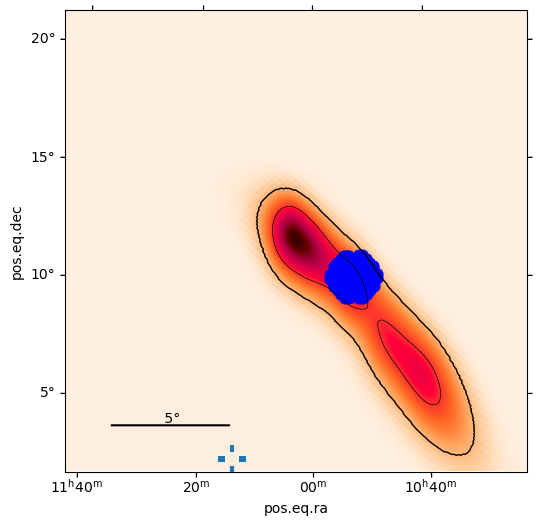

In [7]:
name = 'S240413'
url = 'S240413p_flatten.fits'
date = str(datetime.date.today())
area50, area90, maxprob_ra, maxprob_dec, maxprob_dist, maxprob_distsigma, levels, nside, prob = af.make_alert_skymap(url)

center = SkyCoord(maxprob_ra, maxprob_dec, unit="deg")  # defaults to ICRS frame
# print(maxprob_ra)

fig = plt.figure(figsize=(6, 6), dpi=100)
plt.box(False)
plt.xticks([])
plt.yticks([])

ax = plt.axes(
    projection='astro zoom',
    center=center,
    radius=10*u.deg)

for key in ['ra', 'dec']:
    ax.coords[key].set_ticklabel_visible(True)
    ax.coords[key].set_ticks_visible(True)


ax.scalebar((0.1, 0.1), 5 * u.deg).label()

ct = ax.contour_hpx(url, levels = levels, colors = ['black'], linewidths = [1,0.5])

ax.imshow_hpx(url, cmap='cylon')
ax.plot(
    maxprob_ra, maxprob_dec,
#     transform=ax.get_transform('world'),
    marker=ligo.skymap.plot.reticle(),
    markersize=20,
    markeredgewidth=3)
    
# for i in range(len(supertotal_ras)):
#ax.scatter(eventra, eventdec, transform=ax.get_transform('world'), color='purple')

# ax.scatter(ra, dec, transform = ax.get_transform('world'))
sc = ax.scatter([], [], transform=ax.get_transform('world'), alpha=0.5, color=[])


def animate(i):
    sc.set_offsets(list(zip(everyra[i], everydec[i])))
    if filt_list[i]=='r':
        sc.set_color('red')
    elif filt_list[i]=='i':
        sc.set_color('blue')
    else:
        sc.set_color('green')

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(everyra), interval=1000, repeat=False)

from IPython.display import HTML
HTML(ani.to_jshtml())
# writer = matplotlib.anima